In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
#plt.rcParams["figure.figsize"] = 10, 8
#plt.rcParams["font.size"     ] = 14

plt.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": "xx-large",
    "axes.labelsize": "xx-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.fontsize": "large",
    "figure.titlesize": "xx-large",
    "legend.frameon": False,
    "text.usetex": True
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob

In [110]:
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [15]:
from pymono.config import CsI_6x6_sidewrap_50k_2MHzDC_PTFE_LUT_fano_NX

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [8]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [9]:
from pymono.cnn_func import ResNet10

In [10]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# CsI_6x6_sidewrap_50k_2MHzDC_PTFE_LUT_fano_NX

- Study performance of a CsI monolithic crystal (all but entry side reflectant, entry side black).
- Fano factor included

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point (CsI, with ~100 k photons/MeV)
- 2MHzDC (??)
- PTFE wrapping (all sides but entry face)
- LUT model
- Fano factor 

## Setup

In [16]:
crystal = CsI_6x6_sidewrap_50k_2MHzDC_PTFE_LUT_fano_NX

In [17]:
crystal

'/Users/jjgomezcadenas/data/monolith/CsI_6x6_sidewrap_50k_2MHzDC_PTFE_LUT_fano_NX'

In [18]:
imgs, mdata = select_image_and_lbl(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


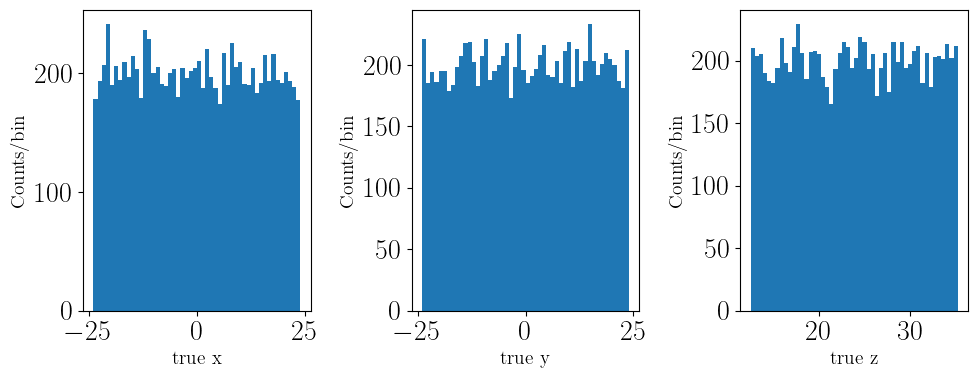

In [108]:
plot_true_positions(mdata)

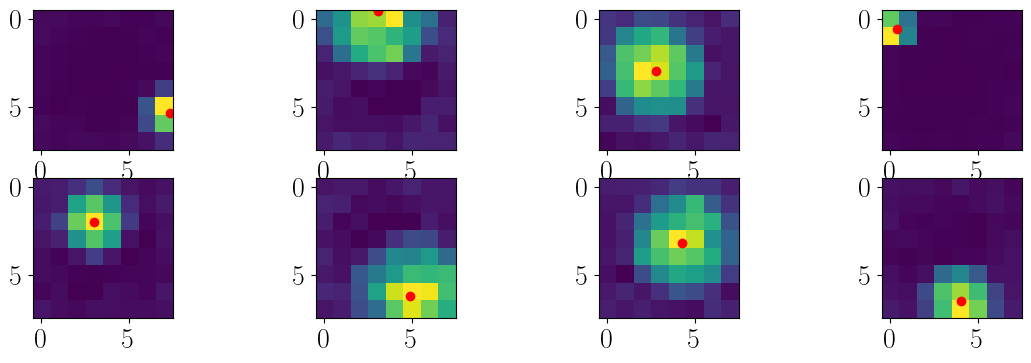

In [109]:
plot_images(imgs, mdata, range(0,8))

In [21]:
imgs[0]

array([[ 17.,  19.,  10.,  10.,  15.,   8.,   8.,  15.],
       [ 21.,  14.,   8.,   6.,   1.,   6.,  12.,   7.],
       [ 14.,   7.,   4.,   2.,   4.,   2.,   8.,   9.],
       [ 13.,   7.,   2.,   6.,   1.,   3.,   4.,   5.],
       [ 12.,   6.,   3.,   2.,   1.,   7.,  18., 128.],
       [  7.,   3.,   7.,   4.,   5.,   4., 176., 679.],
       [ 21.,  12.,  13.,   4.,   5.,  14., 151., 517.],
       [ 16.,  11.,  16.,  16.,  11.,  18.,  35.,  89.]], dtype=float32)

In [22]:
np.mean(imgs[0])

35.609375

In [23]:
np.std(imgs[0])

106.99542

In [24]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


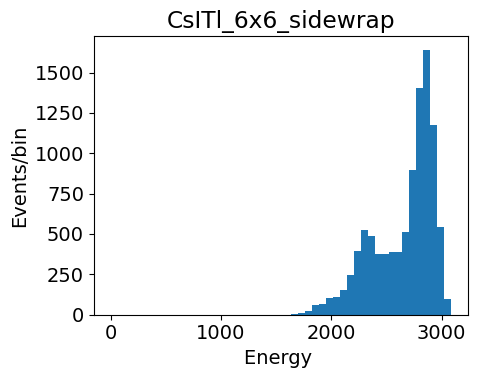

In [25]:
plot_energies2({"CsITl_6x6_sidewrap":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [26]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} resolution (FWHM)  = {100*fwhm6x6:.2f} %")

mean = 2657.64 resolution (FWHM)  = 24.20 %


## Calibrate energy

In [71]:
first_file = 0  # initial file indx
last_file  = 100 


In [76]:
def get_images_and_metadata(data_path, frst_file, lst_file):
    
    img_name, lbl_name, indx = files_list_npy_csv(data_path)
    print(f"Loading files with indexes: {indx[frst_file:lst_file]}")

    images = []
    metadata = []

    for i in indx[frst_file:lst_file]:
        image = np.load(f'{data_path}/{img_name}_{i}.npy')
        meta  = np.loadtxt(f'{data_path}/{lbl_name}_{i}.csv', delimiter=",", skiprows=1)
        images.append(image)
        metadata.append(meta)
        
    metadata = np.vstack(metadata)
    images   = np.vstack(images)
    energies = np.sum(images, axis=(1, 2))
    return images, metadata, energies

In [77]:
images, metadata, energies = get_images_and_metadata(crystal, first_file, last_file)

Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [70]:
images[1]

array([[ 18.,  14.,  13.,  15.,  13.,  15.,  13.,  15.],
       [ 17.,  12.,  23.,   7.,  10.,  13.,  12.,  15.],
       [ 28.,  94., 195., 111.,  11.,   3.,   4.,  14.],
       [ 55., 202., 296., 219.,  66.,   4.,   6.,  12.],
       [ 53., 196., 264., 211.,  60.,   3.,   2.,  12.],
       [ 17.,  68., 141.,  71.,   6.,   7.,   4.,  13.],
       [ 22.,  11.,  10.,   6.,   9.,   8.,  14.,  13.],
       [ 20.,  24.,  16.,  11.,  10.,   8.,  14.,  12.]], dtype=float32)

In [85]:
metadata[:, 1]

array([-17.736462 ,  -0.8838684,  21.183115 , ...,  12.495941 ,
       -18.785889 , -16.627571 ])

In [92]:
def energy_interpolator(charges, metadata, xbins=(10,10,10)):
    def get_2d_bin_contents_from_meshgrid(
        x_values,
        y_values,
        z_values,
        x_bin_edges,
        y_bin_edges,
        z_bin_edges,
        histogram_contents,
    ):
        # Flatten the 2D arrays to use np.digitize
        x_values_flat = x_values.ravel()
        y_values_flat = y_values.ravel()
        z_values_flat = z_values.ravel()
    
        # Use np.digitize to find the bin indices for each dimension
        x_bins_flat = np.digitize(x_values_flat, x_bin_edges) - 1
        y_bins_flat = np.digitize(y_values_flat, y_bin_edges) - 1
        z_bins_flat = np.digitize(z_values_flat, z_bin_edges) - 1
    
        # Adjust bin indices to handle values that are out of bounds
        x_bins_flat = np.clip(x_bins_flat, 0, len(x_bin_edges) - 2)
        y_bins_flat = np.clip(y_bins_flat, 0, len(y_bin_edges) - 2)
        z_bins_flat = np.clip(z_bins_flat, 0, len(z_bin_edges) - 2)
    
        # Access the histogram contents using the flattened bin indices
        bin_contents_flat = histogram_contents[x_bins_flat, y_bins_flat, z_bins_flat]
    
        # Reshape the flat bin contents back to the original meshgrid shape
        bin_contents = bin_contents_flat.reshape(x_values.shape)
    
        return bin_contents
        
    xx = metadata[:, 1]
    yy = metadata[:, 2]
    zz = metadata[:, 3]
    
    n, bins = np.histogramdd([xx, yy, zz], weights=charges, bins=xbins)
    x_edges = bins[0]
    y_edges = bins[1]
    z_edges = bins[2]
    histogram_contents = n
    
    # Generate a mesh grid of x and y values
    x = np.linspace(min(xx), max(xx), xbins[0])
    y = np.linspace(min(yy), max(yy), xbins[1])
    z = np.linspace(min(zz), max(zz), xbins[2])
    
    x_values, y_values, z_values = np.meshgrid(x, y, z, indexing="ij")
    
    # Get bin contents for the mesh grid of points
    bin_contents = get_2d_bin_contents_from_meshgrid(
        x_values, y_values, z_values, x_edges, y_edges, z_edges, histogram_contents
    )
    
    # print("Bin contents for the mesh grid of points:")
    return RegularGridInterpolator((x, y, z), bin_contents/np.max(bin_contents))
    

In [93]:
interp =  energy_interpolator(energies, metadata, xbins=(10,10,10))

In [94]:
def corrected_energy(energies, metadata, interp):
    xx = metadata[:, 1]
    yy = metadata[:, 2]
    zz = metadata[:, 3]
    return energies / interp(np.vstack([xx, yy, zz]).T)

In [119]:
def plot_corrected_energies(energies, metadata, interp, bins=100, erange= (1000, 3200), density=True, figsize=(10, 6)):
    
    cenergies = corrected_energy(energies, metadata, interp)
    
    fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)
    
    _ = ax.hist(cenergies, bins=bins, range=erange, density=density,
                histtype="step", color="k", lw=2,
                label=f"Corrected:\n $\sigma/\mu={np.std(cenergies)/np.mean(cenergies)*100:.2f}\%$")
    _ = ax.hist(energies, bins=bins, range=erange, density=density,
                histtype="step", color="r", lw=2,
                label=f"Uncorrected:\n $\sigma/\mu={np.std(energies)/np.mean(energies)*100:.2f}\%$")


    ax.legend()
    ax.set_xlabel("Charge [\# p.e.]")
    ax.set_title("CsI w/ dark face")
    ax.set_xlim(*erange)
    fig.savefig("csi_side_calib.pdf")
    

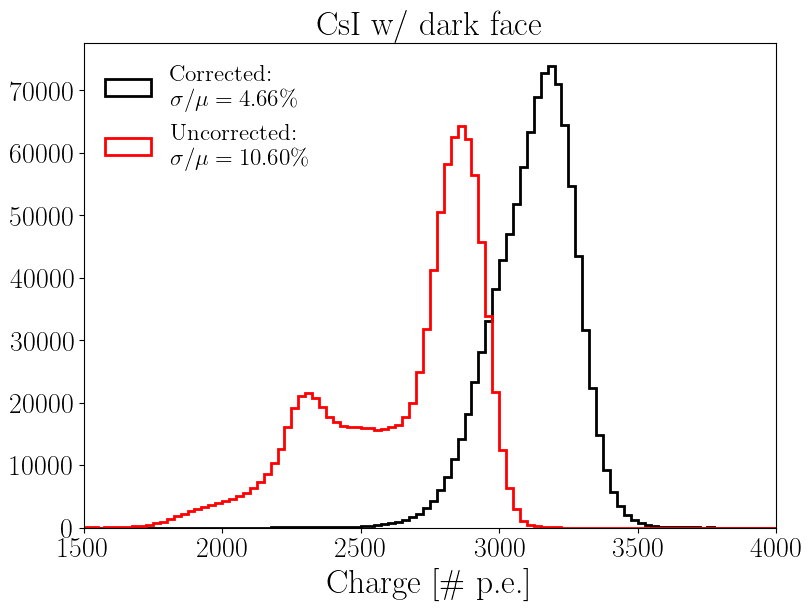

In [120]:
plot_corrected_energies(energies, metadata, interp, bins=100, density=False, erange= (1500, 4000), figsize=(8, 6))

In [118]:
def fit_gaussian(xdata, ydata, pars=[10000., 0.5, 2.0]):
    def gaussian(x, a1, mu1, sigma1):
        return a1*(np.exp(-(x-mu1)**2/(2*sigma1**2)))
        
    pars, cov = curve_fit(gaussian, xdata, ydata, p0=pars)
    err       = np.sqrt(np.diag(cov))
    fit_y     = gaussian(xdata, *pars) 
    return pars, err, fit_y 

In [127]:
def fitene(energies, metadata, interp, bins=100):
    def bin_centers(bins):
        return np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
        
    cenergies = corrected_energy(energies, metadata, interp)
    he, ebins = np.histogram(cenergies, bins=bins)
    xdata = bin_centers(ebins)
    ydata = he

    
    pars, err, yfit = fit_gaussian(xdata, ydata, pars=[100000., 3000, 500])
    return xdata, ydata, yfit, pars[1], pars[2]
    
   

In [128]:
xdata, ydata, yfit, mu, sigma = fitene(energies, metadata, interp, bins=100)
print(f"2g fit: mu = {mu:.2f}, sigma = {sigma:.2f}")

2g fit: mu = 3145.26, sigma = 139.43


In [135]:
def plotfz(xdata, ydata, yfit, mu, sigma, figsize=(8, 6)):
   
    fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)
    ax.errorbar(xdata, ydata, yerr=np.sqrt(ydata), fmt='o', markersize=2)
    ax.plot(xdata, yfit, 'red', linewidth=1.0, 
            label=f"Corr E:\n $R (FWHM)={2.355* 100*sigma/mu:.2f}\%$")
    ax.legend()
    
    ax.set_xlabel("Charge")
    ax.set_ylabel("Counts/bin")
    #fig.tight_layout()
    plt.show()

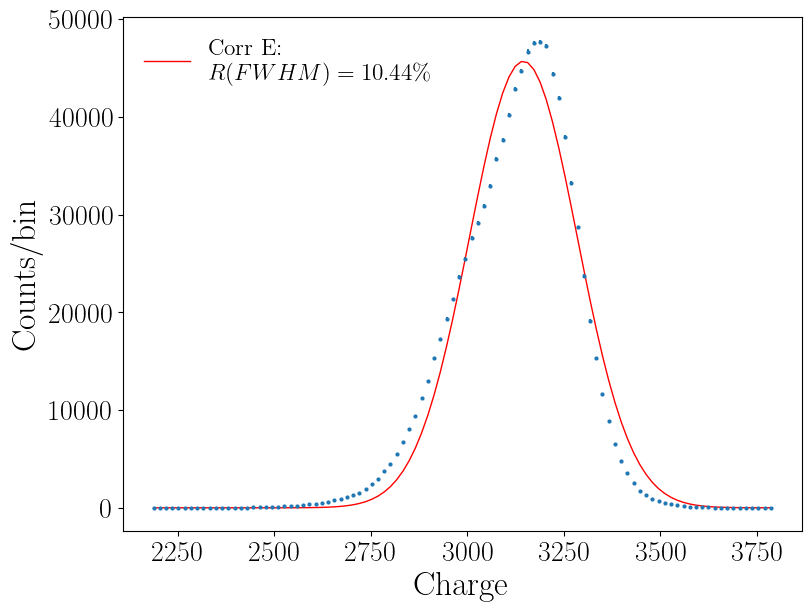

In [136]:
plotfz(xdata, ydata, yfit, mu, sigma, figsize=(8, 6))

In [138]:
1.7*7/10

1.19

## FF network

In [41]:
ffmodel = FF(dropout=True).to(device)
print(ffmodel)
optimizer = optim.Adam(ffmodel.parameters(), lr=0.001)
criterion = nn.MSELoss()

FF(
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)


In [29]:
class FFMonoDataset(Dataset):
    """
    Loads the data to pytorch 
    self.dataset ->[d1, d2...] where di ->[(x,y,z,eobs), vector (etrue)]
    
    """

    def __init__(self, data_path: str, frst_file: int, lst_file: int,
                norm=False, xnorm=(24.0, 12.5, 35.3, 4700.0)):

        def normz(z):
            return (z - xnorm[1])/(xnorm[2] - xnorm[1])
            
        self.dataset = []
        img_name, lbl_name, indx = files_list_npy_csv(data_path)
        print(f"Loading files with indexes: {indx[frst_file:lst_file]}")

        ii = 0
        for i in indx[frst_file:lst_file]:
            images = np.load(f'{data_path}/{img_name}_{i}.npy')
            metadata = pd.read_csv(f'{data_path}/{lbl_name}_{i}.csv')
            
            for img, meta in zip(images, metadata.values):
                #ii=+1
                #print(f"img = {img}, sum = {np.sum(img)}")
                #print(f"meta = {meta}")
                xx = np.array([meta[1], meta[2], meta[3], np.sum(img)])
                yy = np.array(meta[4])

                if norm:
                    xx = np.array([meta[1]/xnorm[0], meta[2]/xnorm[0], normz(meta[3]), 
                                   np.sum(img/xnorm[3])])
                    yy = np.array(meta[4]/xnorm[3]) 
                self.dataset.append((xx,yy))
                #if ii >3 : break

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        xyze, etrue = self.dataset[idx]
        #print(f"xyze ={xyze}, etrue={etrue}")
        xyze = torch.tensor(xyze, dtype=torch.float)
        etrue = torch.tensor(etrue, dtype=torch.float).unsqueeze(0)

        return xyze, etrue

In [31]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2
fdataset = FFMonoDataset(crystal, first_file, last_file)

Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [32]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(fdataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   


Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [33]:
xyzeb, etb = next(iter(train_loader)) 
print(f"read xyze batch, size->{xyzeb.size()}")
print(f"read et batch, size->{etb.size()}")
xyze = xyzeb[0].squeeze()
et = etb[0].squeeze()
print(xyze)
print(et)

read xyze batch, size->torch.Size([1000, 4])
read et batch, size->torch.Size([1000, 1])
tensor([   3.1881,   15.5692,   27.2076, 2833.0000])
tensor(49859.)


In [34]:
def get_xyze_max(tl):
    def min_max(value, min, max):
        if value < min: 
            min = value
        if value > max: 
            max = value
        return min, max

    xmin, ymin, zmin = 1e+6, 1e+6, 1e+6
    xmax, ymax, zmax = -1e+6, -1e+6, -1e+6
    emin, emax = 1e+6, -1e+6
    etmin, etmax = 1e+6, -1e+6

    for i in range(30):
        xyzeb, etb = next(iter(train_loader))
    
        for xyzet in xyzeb:
            xyze = xyzet.squeeze()
            xmin, xmax = min_max(xyze[0].item(), xmin, xmax)
            ymin, ymax = min_max(xyze[1].item(), ymin, ymax)
            zmin, zmax = min_max(xyze[2].item(), zmin, zmax)
            emin, emax = min_max(xyze[3].item(), emin, emax)
        
        for ett in etb:
            et = ett.squeeze()
            etmin, etmax = min_max(etb[0].item(), etmin, etmax)
    return xmin, xmax, ymin, ymax, zmin, zmax, emin, emax, etmin, etmax


In [35]:
get_xyze_max(train_loader)

(-23.99808692932129,
 23.999561309814453,
 -23.997310638427734,
 23.999752044677734,
 12.501614570617676,
 35.29969024658203,
 1594.0,
 3199.0,
 49363.0,
 50809.0)

In [37]:
ndataset = FFMonoDataset(crystal, first_file, last_file, norm=True, xnorm=(24.0, 12.5, 35.3, 50000.0))

Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [38]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(ndataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   


Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [39]:
get_xyze_max(train_loader)

(-0.9999585151672363,
 0.9999649524688721,
 -0.999958336353302,
 0.999893844127655,
 2.4035087335505523e-05,
 0.999995768070221,
 0.030460000038146973,
 0.06325999647378922,
 0.984499990940094,
 1.010740041732788)

In [42]:
def single_runf(train_loader, device, model, optimizer, criterion):
    print(f"** Run for 1 event**")

    for epoch in range(1):
        print(f"epoch = {epoch}")
    
        for i, (images, labels) in enumerate(train_loader):  
            if i>5: break
            print(f"i = {i}")
            print(f"xyze (shape) = {images.shape}")
            print(f"et (shape) = {labels.shape}")

            im0 = images[0]
            lbl0 = labels[0]

            print(f"xyze (0) = {im0}")
            print(f"et0  = {lbl0}")
            
            images = images.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            print(f"outputs = {outputs.shape}")
            out0 = outputs[0]
            print(f"out0  = {out0}")

            loss = criterion(outputs, labels)
            
            # Backward and optimize
            
            loss.backward()
            optimizer.step()
    
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")


In [43]:
single_runf(train_loader, device, ffmodel, optimizer, criterion)

** Run for 1 event**
epoch = 0
i = 0
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([1000, 1])
xyze (0) = tensor([-0.9564, -0.2000,  0.0445,  0.0435])
et0  = tensor([0.9963])
outputs = torch.Size([1000, 1])
out0  = tensor([0.5588], device='mps:0', grad_fn=<SelectBackward0>)
Train Step 1/700, Loss: 0.21390052139759064
i = 1
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([1000, 1])
xyze (0) = tensor([0.5605, 0.9405, 0.6058, 0.0486])
et0  = tensor([0.9977])
outputs = torch.Size([1000, 1])
out0  = tensor([0.5820], device='mps:0', grad_fn=<SelectBackward0>)
Train Step 2/700, Loss: 0.21238312125205994
i = 2
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([1000, 1])
xyze (0) = tensor([0.0540, 0.7646, 0.3294, 0.0520])
et0  = tensor([0.9968])
outputs = torch.Size([1000, 1])
out0  = tensor([0.5076], device='mps:0', grad_fn=<SelectBackward0>)
Train Step 3/700, Loss: 0.21110549569129944
i = 3
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([100

In [44]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    ffmodel, optimizer, device, criterion, 
                                    batch_size, epochs=3, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->3

EPOCH 0
Train Step 200/700, Loss: 0.09572821855545044
Train Step 400/700, Loss: 0.04714048281311989
Train Step 600/700, Loss: 0.027138058096170425
Validation Step 200/200, Loss: 0.01781652867794037
--- EPOCH 0 AVG TRAIN LOSS: 0.0744202043754714
--- EPOCH 0 AVG VAL LOSS: 0.017883854191750287

EPOCH 1
Train Step 200/700, Loss: 0.015383148565888405
Train Step 400/700, Loss: 0.010669127106666565
Train Step 600/700, Loss: 0.008687273599207401
Validation Step 200/200, Loss: 0.004627383314073086
--- EPOCH 1 AVG TRAIN LOSS: 0.012921664380202336
--- EPOCH 1 AVG VAL LOSS: 0.004659624276682734

EPOCH 2
Train Step 200/700, Loss: 0.006797214038670063
Train Step 400/700, Loss: 0.005367533769458532
Train Step 600/700, Loss: 0.0053644985891878605
Validation Step 200/200, Loss: 0.0018653417937457561
--- EPOCH 2 AVG TRAIN LOSS: 0.0060295513864340525

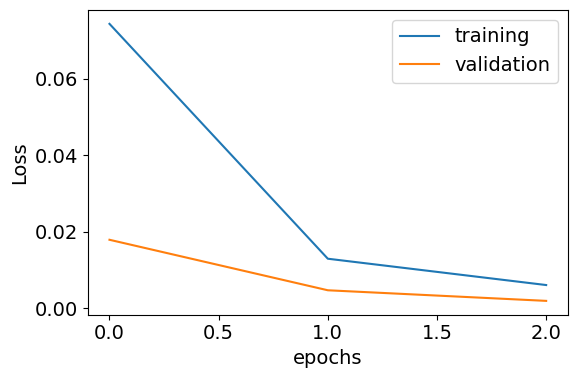

In [45]:
plot_loss(3, train_losses, val_losses,figsize=(6, 4))

In [46]:
def evaluate_ff(test_loader, model, device):
    
    true_e = []
    meas_e = []
    predicted_e = []
    
    with torch.no_grad():
        model.eval()
        for i, (xyze, et) in enumerate(train_loader): 
            
            for e in xyze[:,3]: meas_e.append(e)
            for e in et[:,0]: true_e.append(e)
                
            xyze = xyze.to(device)
            outputs = model(xyze).cpu()
            
            for e in outputs[:,0]: predicted_e.append(e)
            
    true_e = np.array(true_e); meas_e = np.array(meas_e); predicted_e = np.array(predicted_e)
    delta_e_NN = true_e - predicted_e
    return true_e, meas_e, predicted_e, delta_e_NN


In [47]:
true_e, meas_e, predicted_e, delta_e_NN = evaluate_ff(test_loader, ffmodel, device)

In [48]:
predicted_e[0:10]

array([0.9561863 , 0.9564819 , 0.95734507, 0.9575838 , 0.95744187,
       0.95724905, 0.9571955 , 0.957266  , 0.956397  , 0.95727265],
      dtype=float32)

In [49]:
delta_e_NN[0:10]

array([0.0377537 , 0.04609817, 0.03137493, 0.03481621, 0.04441816,
       0.03605098, 0.04138446, 0.04569399, 0.043163  , 0.03520733],
      dtype=float32)

In [50]:
true_e[0:10]

array([0.99394, 1.00258, 0.98872, 0.9924 , 1.00186, 0.9933 , 0.99858,
       1.00296, 0.99956, 0.99248], dtype=float32)

In [51]:
def sigmaEovE(xe, emax = 4700.0):
    mu = np.mean(xe * emax)
    sigma = np.std(xe * emax)
    return mu, sigma, 100 * sigma/mu, 2.355 * 100 * sigma/mu

In [52]:
sigmaEovE(true_e)

(4699.9995, 28.181084, 0.5995975873813152, 1.4120523182829972)

In [53]:
sigmaEovE(meas_e)

(249.42297, 26.416523, 10.591054462619532, 24.941933259469)

In [54]:
sigmaEovE(predicted_e)

(4497.919, 2.2666678, 0.050393701407785374, 0.11867716681533455)

In [55]:
def xe(true_e, meas_e, predicted_e, delta_e_NN, emax = 4700.0, nbins=50):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 7))
    flat_axes = axes.ravel()
    ax0, ax1, ax2, ax3 = flat_axes[0], flat_axes[1], flat_axes[2], flat_axes[3]
    
    ax0.hist(true_e * emax, bins=nbins, 
             label=f"x ($\sigma$ = {np.std(true_e):.3f})", alpha=0.7)
    ax0.set_xlabel("True energy",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    ax0.legend()

    ax1.hist(meas_e * emax, bins=nbins, 
             label=f"x ($\sigma$ = {np.std(meas_e):.3f})", alpha=0.7)
    ax1.set_xlabel("Measured energy",fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)
    ax1.legend()

    ax2.hist(predicted_e * emax, bins=nbins, 
             label=f"x ($\sigma$ = {np.std(predicted_e):.3f})", alpha=0.7)
    ax2.set_xlabel("Predicted energy",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)
    ax2.legend()
    
    ax3.hist(delta_e_NN * emax, bins=nbins, 
             label=f"y ($\sigma$ = {np.std(delta_e_NN):.3f})", alpha=0.7)
    ax3.set_xlabel("NN (etrue - epredicted)",fontsize=14)
    ax3.set_ylabel("Counts/bin",fontsize=14)
    ax3.legend()
    
    fig.tight_layout()
    plt.show()

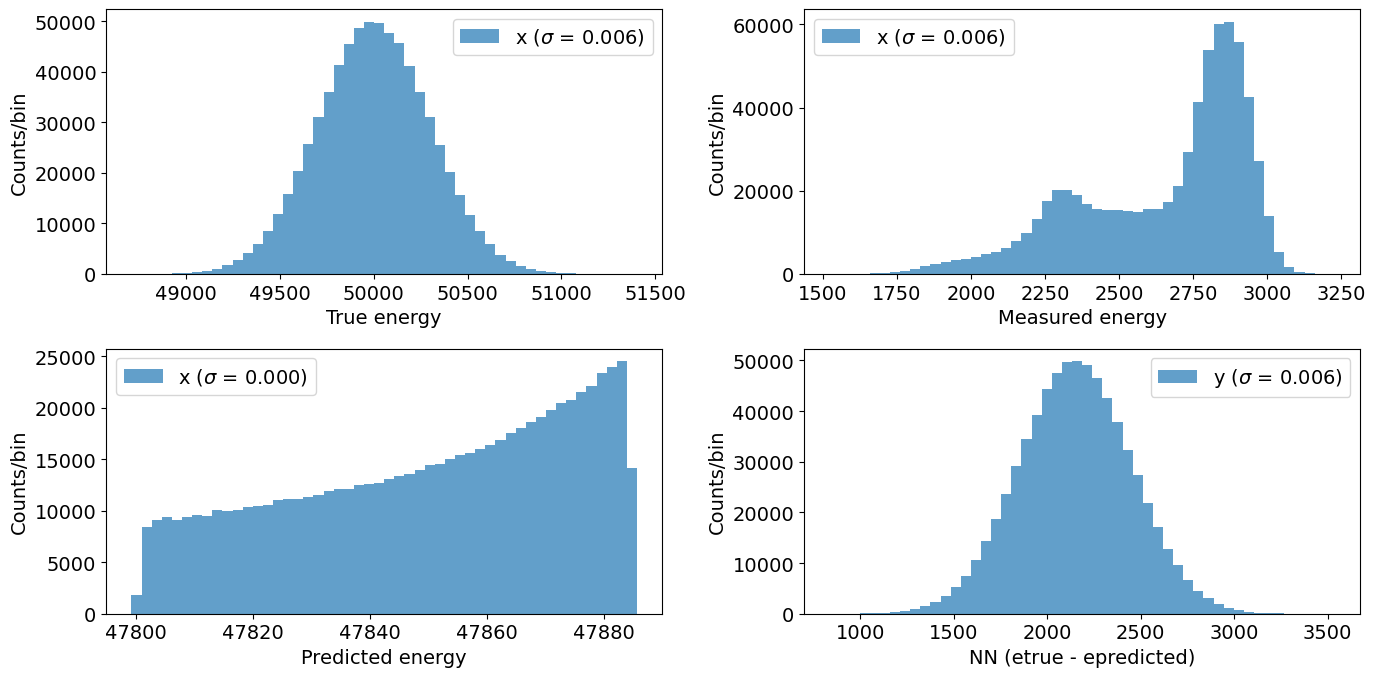

In [57]:
xe(true_e, meas_e, predicted_e, delta_e_NN, emax = 5e+4, nbins=50)

## Data set

In [ ]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [ ]:
dataset = MonoDataset(crystal, first_file, last_file)


In [ ]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

In [ ]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [ ]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

### Train the network with CNN_basic 

In [ ]:
# Load the model.
model = CNN_3x3(dropout=False).to(device)
print(model)

In [ ]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [ ]:
single_run(train_loader, device, model, optimizer,criterion)

In [ ]:
epochs = 10

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

In [ ]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [ ]:
tdeltas = evaluate_cnn(test_loader, model, device)

In [ ]:
#plot_true_predicted(tdeltas, nbins = 50)

In [ ]:
plotxyz(tdeltas, nbins=50)

## Normalize

In [ ]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2
mean=31.96
std=46.79

In [ ]:
dataset = MonoDataset(crystal, 
                      first_file, last_file,
                      norm=True, resize=False, mean=18.6, std=5.0)


In [ ]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

In [ ]:
model = CNN_3x3(dropout=True).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=20, iprnt=300)

In [ ]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


In [ ]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)


In [ ]:
tdeltas

In [ ]:
tdeltas.delta_z_NN

In [ ]:
np.save("/Users/jjgomezcadenas/Projects/pymono/notebooks/delta_z_cnn_bgo.npy", tdeltas.delta_z_NN)

In [ ]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [ ]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [ ]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [ ]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

In [ ]:
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
single_run(train_loader, device, model, optimizer,criterion)

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=200)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
plotxyz(tdeltas, nbins=50)

In [ ]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 250  # Batch size
train_fraction=0.7 
val_fraction=0.2
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=165.90, std=93.3)
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   


In [ ]:
model = ResNet10(ResBlock, debug=False, dropout=True, dropout_fraction=0.2).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=batch_size, epochs=10, iprnt=400)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
tdeltas = evaluate_cnn(test_loader, model, device)
plotxyz(tdeltas, nbins=50)

## Calculation of means

In [ ]:
means, stds = get_means_stds(dir=crystal)

In [ ]:
len(means)

In [ ]:
means[0][0]

In [ ]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

In [ ]:
meansx =[np.mean(x) for x in means]

In [ ]:
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [ ]:
np.mean(meansx)

In [ ]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

In [ ]:
stdsx =[np.std(x) for x in stds]

In [ ]:
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [ ]:
np.mean(stdsx)